Background 
=========================================

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

=========================================
Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

=========================================
Associated tasks
=========================================

	- Regression: 
		Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
	
	- Event and Anomaly Detection:  
		Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
		For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
		identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.


=========================================
Files
=========================================

	- Readme.txt
	- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
	- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

	
=========================================
Dataset characteristics
=========================================	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [143]:
%matplotlib inline

In [144]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import copy

In [145]:
df = pd.read_csv('../data/hour.csv')

In [146]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [147]:
df.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


# Drop uneeded columns

Instant column is an index of the column for the registration index. Will drop the column because it is not needed and will use the same index for all the other columns.
dteday is also not needed. Since we need to answer the question based on season, we will not use this variable.

In [148]:
df = df.drop(['instant', 'dteday'], axis=1)

In [149]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [150]:
df.shape

(17379, 15)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


# Fixing the data types
All variables are Integer are valid data type except for season	yr,	mnth, hr, holiday, weekday	workingday, weathersit. They should be treated as a category.


In [152]:
df["season"] = df["season"].astype('category')
df["yr"] = df["yr"].astype('category')
df["mnth"] = df["mnth"].astype('category')
df["holiday"] = df["holiday"].astype('category')
df["weekday"] = df["weekday"].astype('category')
df["workingday"] = df["workingday"].astype('category')
df["weathersit"] = df["weathersit"].astype('category')


Hour of the day has a natural ordering - 9am is closer to 10am or 8am than it is to 6pm. It is best thought of as a discrete ordinal variable. We will treat it as characteristic of being cyclic.

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  int64   
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  casual      17379 non-null  int64   
 13  registered  17379 non-null  int64   
 14  cnt         17379 non-null  int64   
dtypes: category(7), float64(4), int64(4)
memory usage: 1.2 MB


In [154]:
df.isna().sum()   #null value check

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [155]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


# Basic Scatterplots

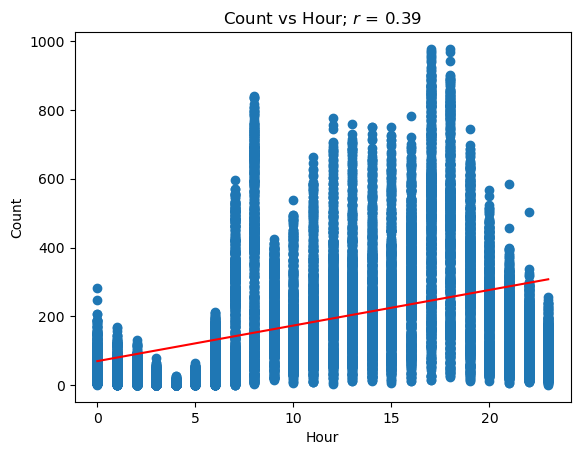

In [156]:
x = df['hr'] 
y = df['cnt']
plt.title('Count vs Hour')
plt.xlabel('Hour')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Hour;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

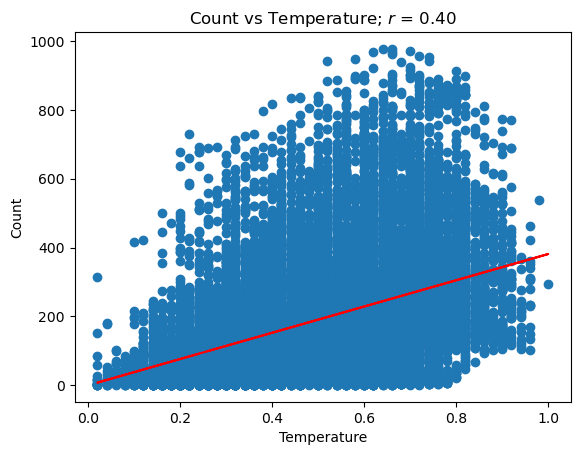

In [157]:
x = df['temp'] 
y = df['cnt']
plt.title('Count vs Temperature')
plt.xlabel('Temperature')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Temperature;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

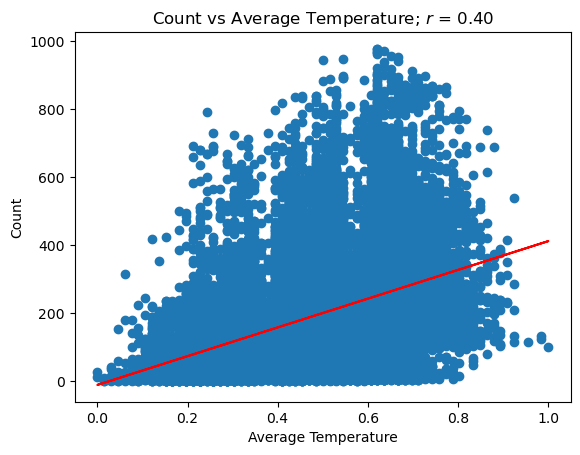

In [158]:
x = df['atemp'] 
y = df['cnt']
plt.title('Count vs Average Temperature')
plt.xlabel('Average Temperature')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Average Temperature;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

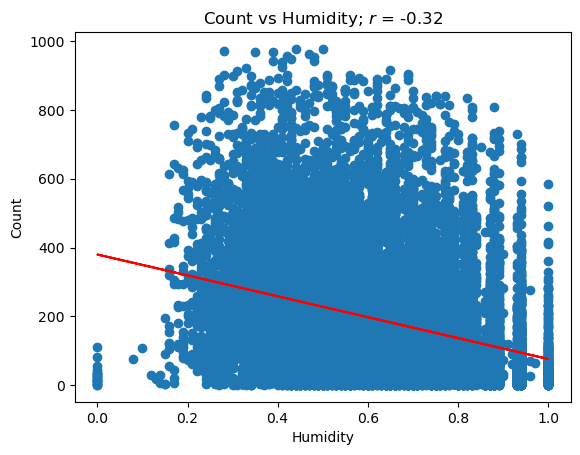

In [159]:
x = df['hum'] 
y = df['cnt']
plt.title('Count vs Humidity')
plt.xlabel('Humidity')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Humidity;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

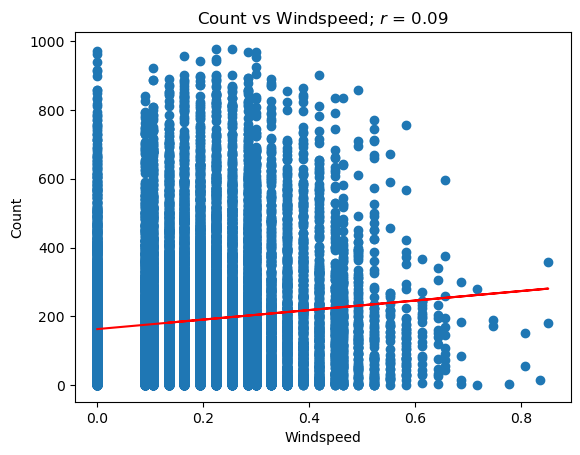

In [160]:
x = df['windspeed'] 
y = df['cnt']
plt.title('Count vs Windspeed')
plt.xlabel('Windspeed')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Windspeed;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

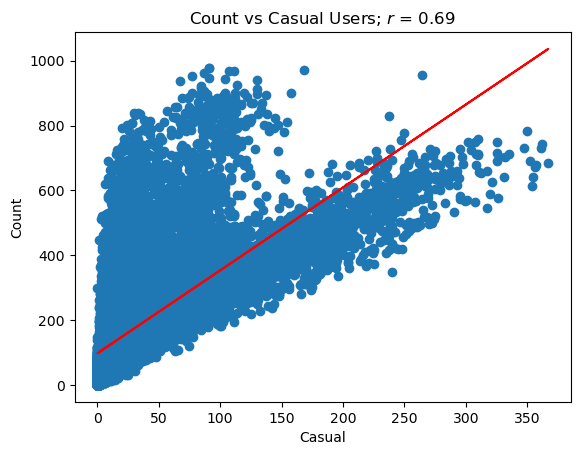

In [161]:
x = df['casual'] 
y = df['cnt']
plt.title('Count vs Casual Users')
plt.xlabel('Casual')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Casual Users;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

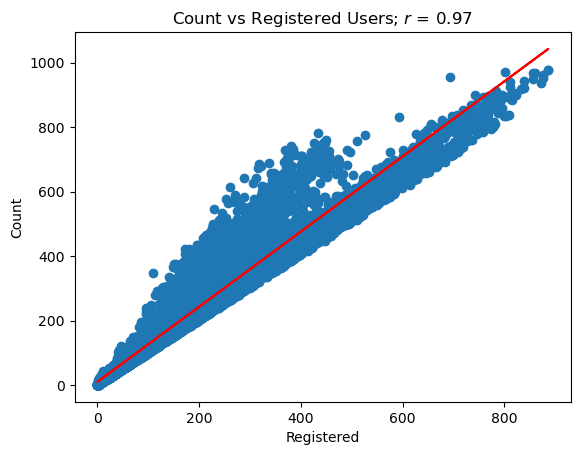

In [162]:
x = df['registered'] 
y = df['cnt']
plt.title('Count vs Registered Users')
plt.xlabel('Registered')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs Registered Users;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

In [163]:
df_enc = pd.get_dummies(df, columns = ['season'])
df_enc.head()


,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4
0,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,0,0,0
1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,0,0,0
2,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,0,0,0
3,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,0,0,0
4,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,0,0,0


In [164]:
df_enc.tail()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4
17374,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,1,0,0,0
17375,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,1,0,0,0
17376,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,1,0,0,0
17377,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,1,0,0,0
17378,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49,1,0,0,0


In [165]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   yr          17379 non-null  category
 1   mnth        17379 non-null  category
 2   hr          17379 non-null  int64   
 3   holiday     17379 non-null  category
 4   weekday     17379 non-null  category
 5   workingday  17379 non-null  category
 6   weathersit  17379 non-null  category
 7   temp        17379 non-null  float64 
 8   atemp       17379 non-null  float64 
 9   hum         17379 non-null  float64 
 10  windspeed   17379 non-null  float64 
 11  casual      17379 non-null  int64   
 12  registered  17379 non-null  int64   
 13  cnt         17379 non-null  int64   
 14  season_1    17379 non-null  uint8   
 15  season_2    17379 non-null  uint8   
 16  season_3    17379 non-null  uint8   
 17  season_4    17379 non-null  uint8   
dtypes: category(6), float64(4), int64(4), uint8(4)

# Univariate Analysis

## Observation on Year

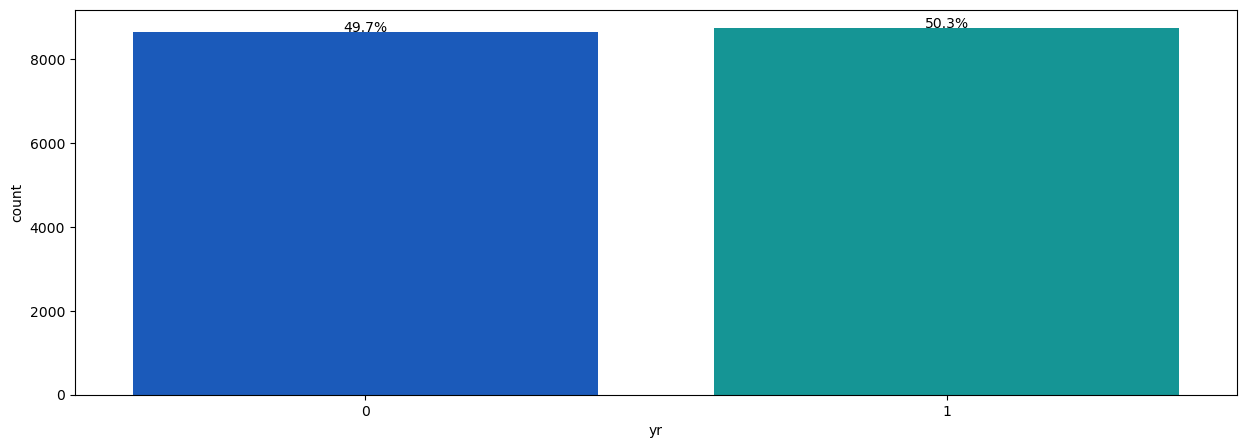

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="yr", palette='winter')
perc_on_bar(ax, df_enc["yr"])
plt.show()


## Observation on mnth

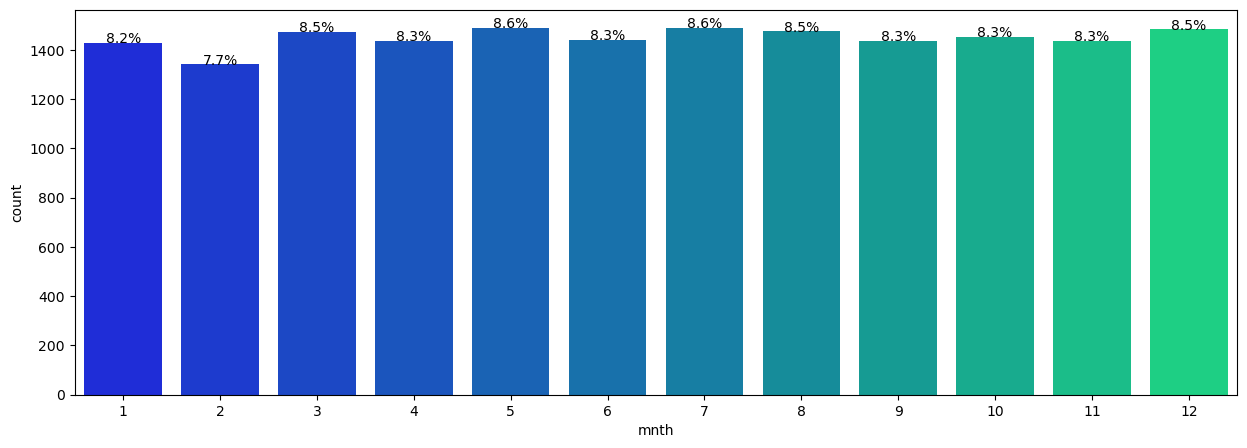

In [196]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="mnth", palette='winter')
perc_on_bar(ax, df_enc["mnth"])
plt.show()


## Observations on hr

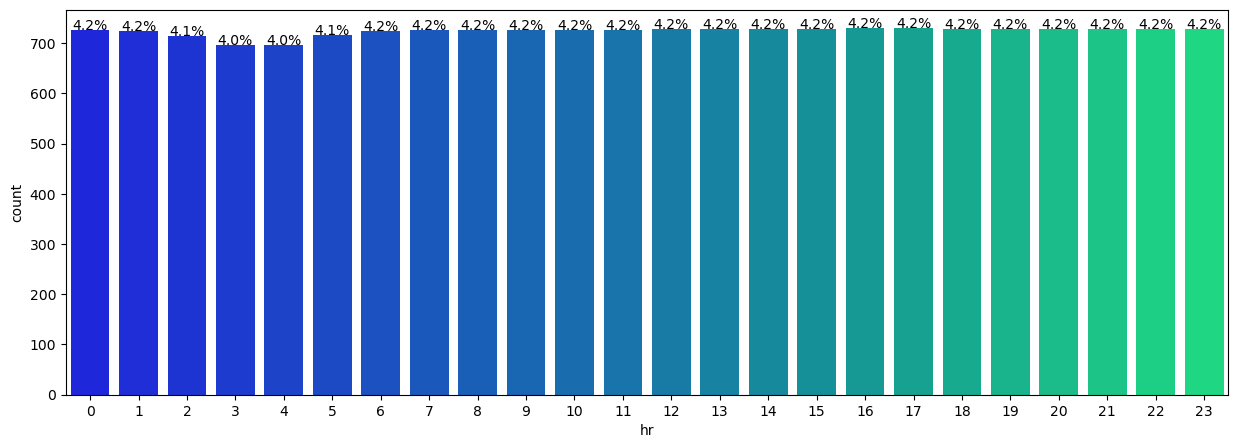

In [197]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="hr", palette='winter')
perc_on_bar(ax, df_enc["hr"])
plt.show()


## Observations on holiday

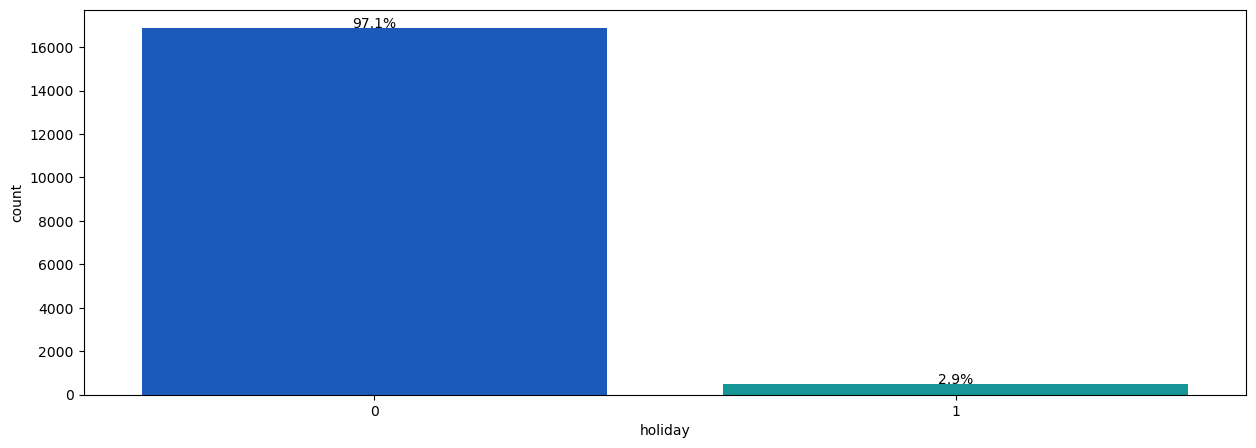

In [198]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="holiday", palette='winter')
perc_on_bar(ax, df_enc["holiday"])
plt.show()


## Observations on weekday

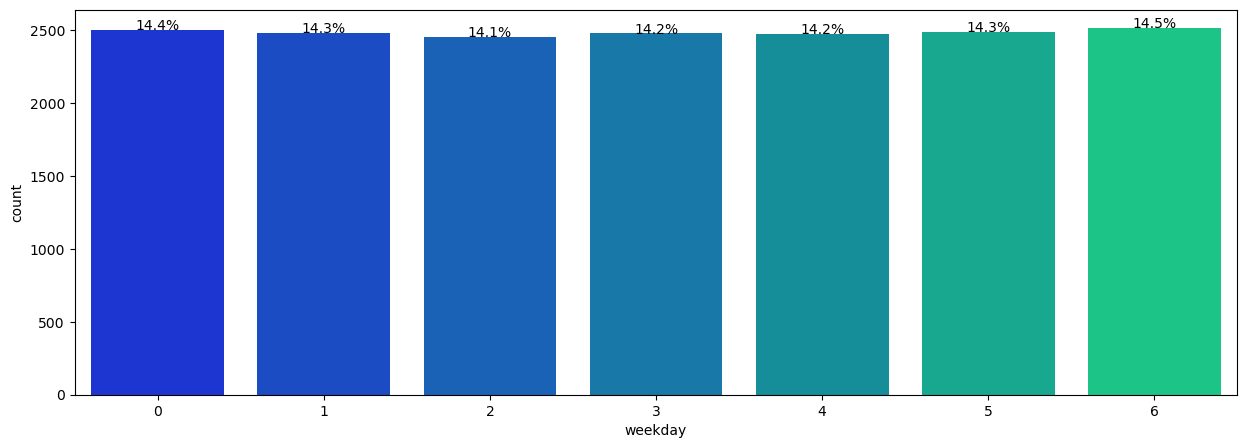

In [199]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="weekday", palette='winter')
perc_on_bar(ax, df_enc["weekday"])
plt.show()


## Observations on workingday

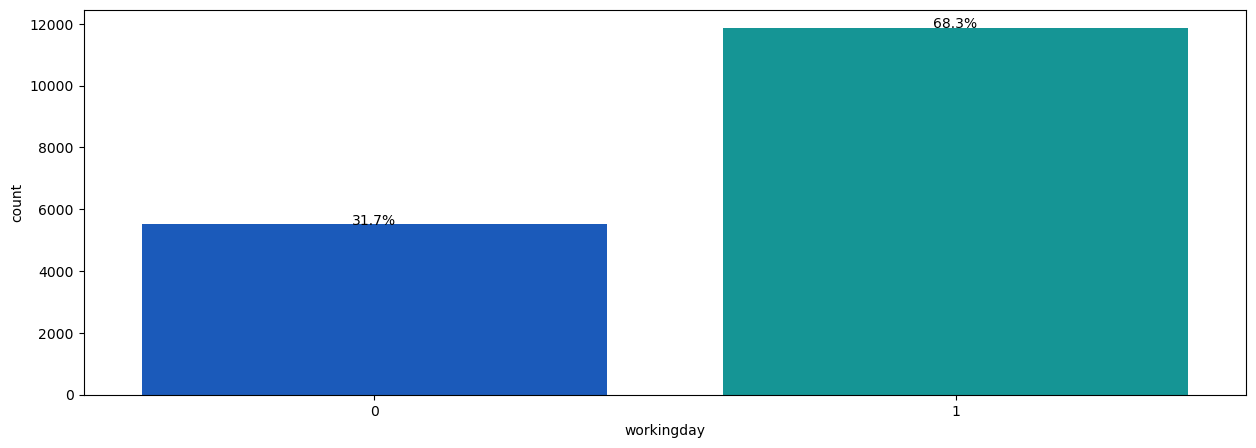

In [201]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="workingday", palette='winter')
perc_on_bar(ax, df_enc["workingday"])
plt.show()


## Observations on weathersit

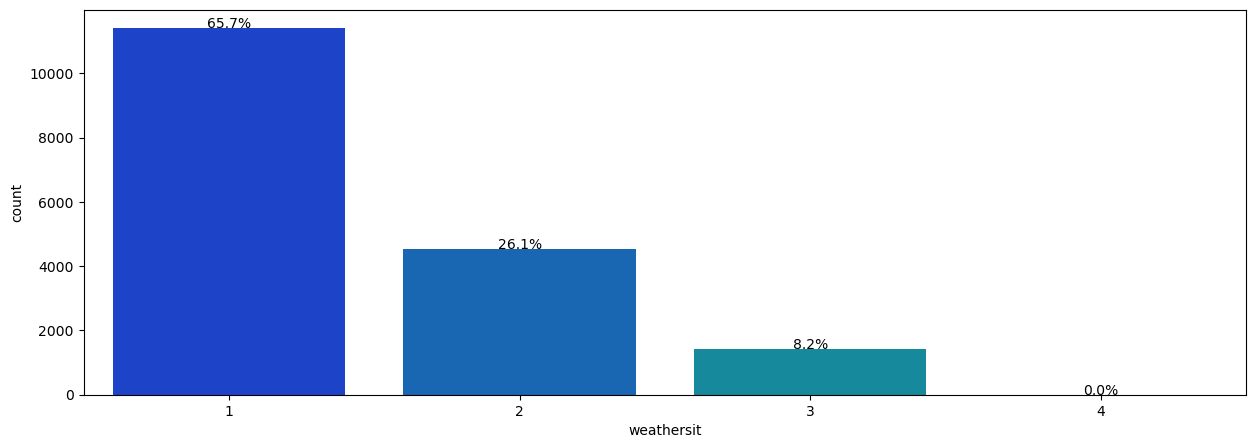

In [203]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="weathersit", palette='winter')
perc_on_bar(ax, df_enc["weathersit"])
plt.show()


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """
    Boxplot and histogram combined.

    Parameters:
    - feature: 1-D feature array
    - figsize: size of the figure (default: (15, 10))
    - bins: number of bins for histogram (default: None/auto)

    Returns:
    - None
    """

    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    sns.boxplot(feature, ax=ax_box, showmeans=True, color='violet')
    
    if bins:
        sns.histplot(feature, kde=False, ax=ax_hist, bins=bins, palette="winter")
    else:
        sns.histplot(feature, kde=False, ax=ax_hist)
    
    ax_hist.axvline(np.mean(feature), color='green', linestyle='--')
    ax_hist.axvline(np.median(feature), color='black', linestyle='-')


# Observations on temp

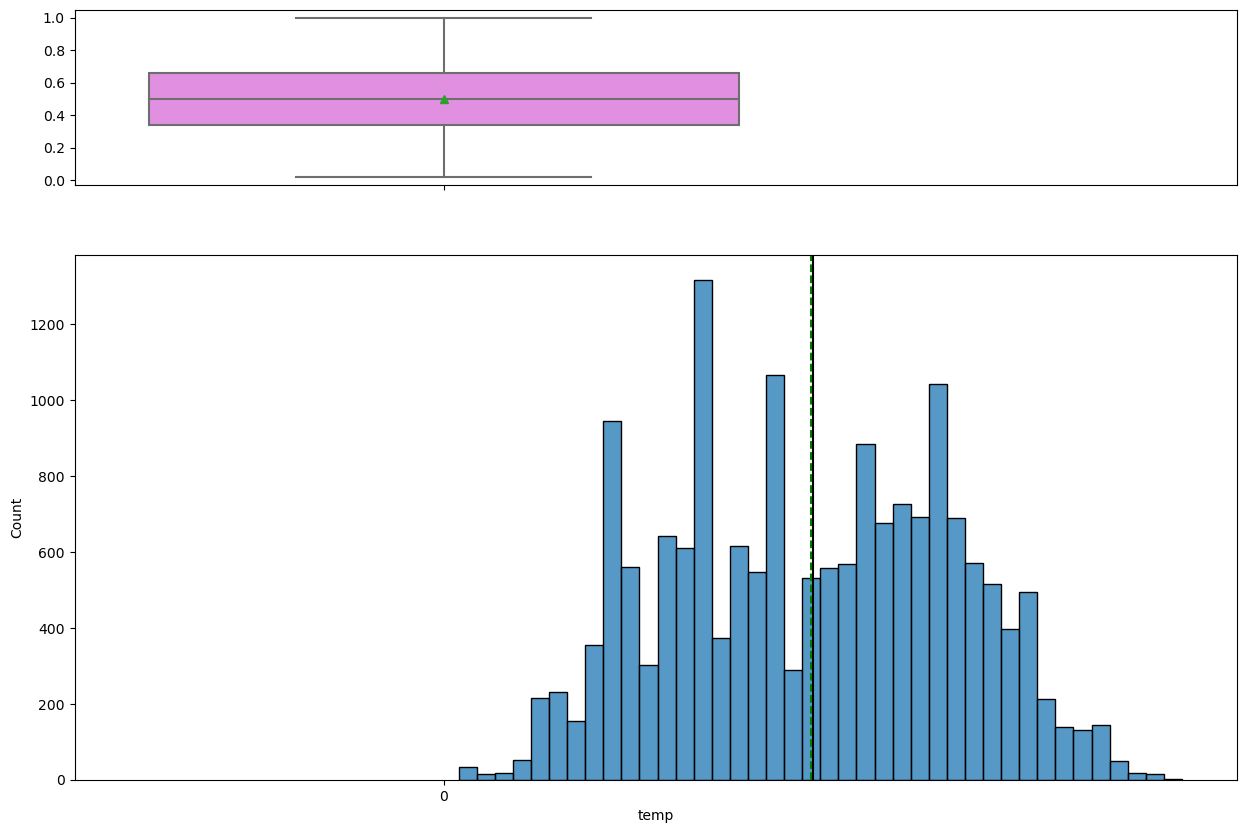

In [168]:
histogram_boxplot(df_enc["temp"])

In [169]:
# univariate analysis
X1 = df_enc['temp']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:34:52   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0356      3.483     -0.010      0.992      -6.862       6.791
temp         381.2949      6.534     58.352      0.000     368.487     394.103
==============================================================================
Omnibus:                     3140.760   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5634.907
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.572   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared value of 0.164 suggests that approximately 16.4% of the variation in the count can be explained by changes in temperature alone. This indicates a relatively weak relationship between temperature and count. The coefficient for 'temp' is 381.2949, suggesting that for every one-unit increase in temperature, the count is expected to increase by approximately 381. However, it's important to note that the constant term is not statistically significant, suggesting that there may be other factors not included in the model that influence the count. Overall

# Observations on atemp

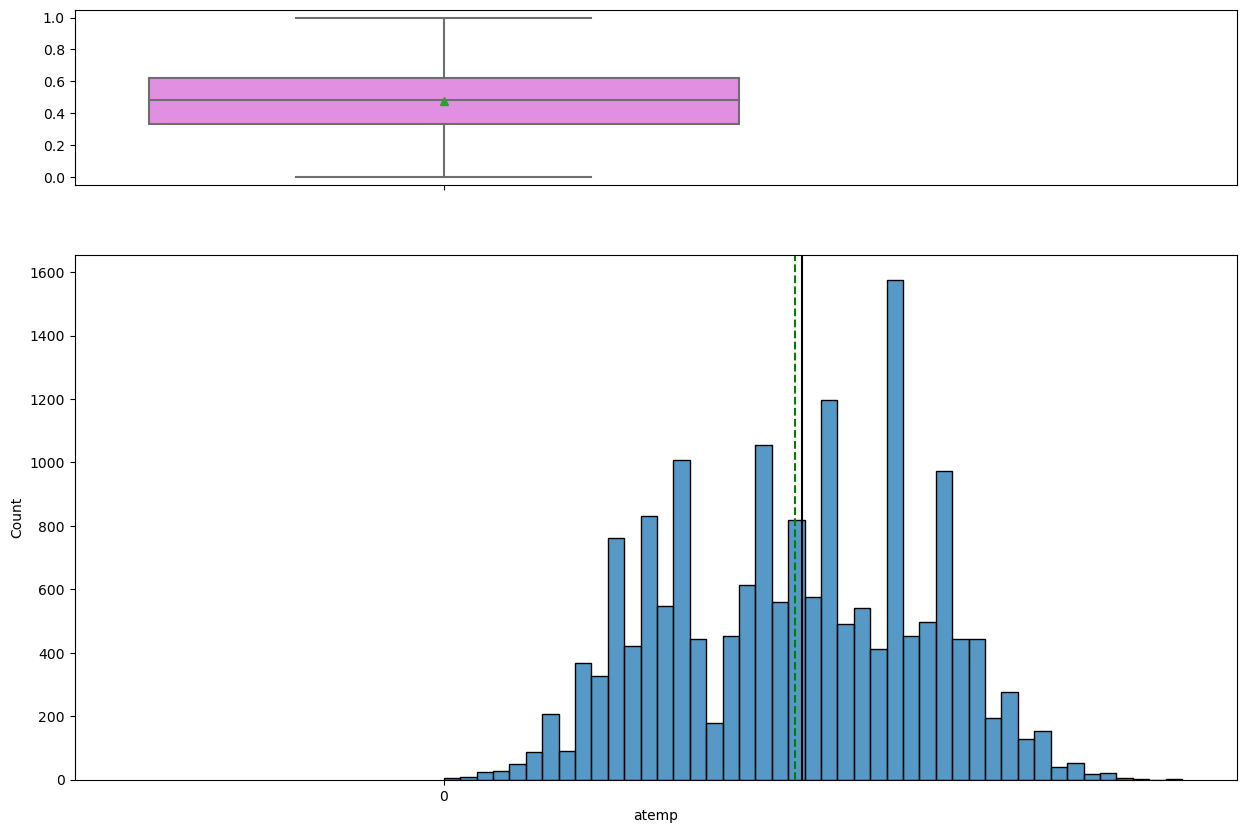

In [170]:
histogram_boxplot(df_enc["atemp"])

In [171]:
# univariate analysis
X1 = df_enc['temp']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:34:52   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0356      3.483     -0.010      0.992      -6.862       6.791
temp         381.2949      6.534     58.352      0.000     368.487     394.103
==============================================================================
Omnibus:                     3140.760   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5634.907
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.572   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The interpretation and conclusions drawn from the second set of results are the same as the first set.

# Observations on humidity

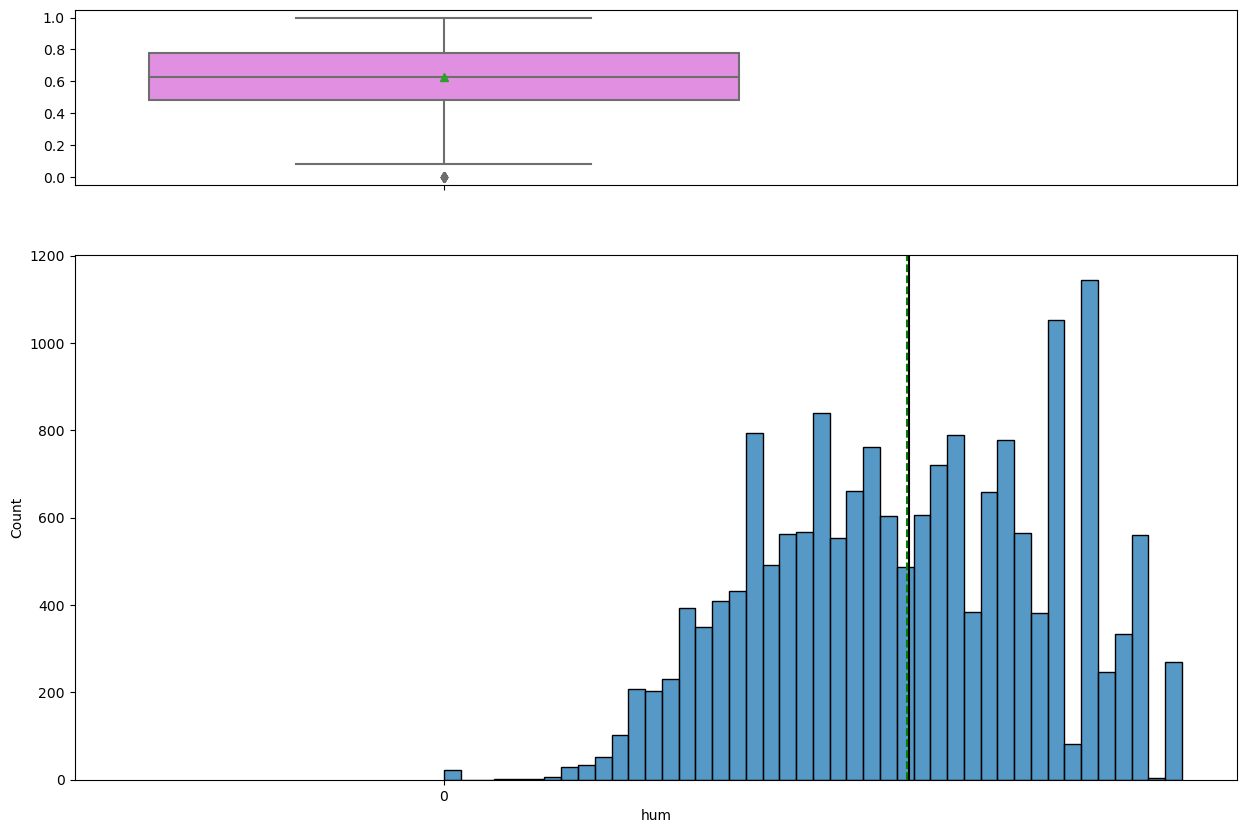

In [172]:
histogram_boxplot(df_enc["hum"])

In [173]:
# univariate analysis
X1 = df_enc['hum']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2023.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:34:53   Log-Likelihood:            -1.1408e+05
No. Observations:               17379   AIC:                         2.282e+05
Df Residuals:                   17377   BIC:                         2.282e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        379.8849      4.430     85.761      0.000     371.202     388.567
hum         -303.5923      6.750    -44.976      0.000    -316.823    -290.361
==============================================================================
Omnibus:                     3480.028   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6472.551
Skew:                           1.250   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         7.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression results show that the model predicts the 'cnt' (count) variable using the 'hum' (humidity) variable. The R-squared value of 0.104 indicates that approximately 10.4% of the variation in count can be explained by changes in humidity alone. The coefficient for 'hum' is -303.5923, suggesting that for every one-unit increase in humidity, the count is expected to decrease by approximately 303. The constant term is statistically significant, with a coefficient of 379.8849, indicating that it has an independent effect on the count. The additional statistics, such as the F-statistic, AIC, BIC, Omnibus, Durbin-Watson, Jarque-Bera, skewness, and kurtosis, provide further insights into the model's performance and assumptions. Overall, the model suggests that humidity has a statistically significant impact on the count, but it only explains a relatively small portion of the total variation in the count.

# Multiple Variable Regression

In [174]:
# assign independent variables, dependent variable, respectively
x = df_enc.loc[:, df_enc.columns != 'cnt']
# define the target
y = pd.DataFrame(df_enc['cnt'])


In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    random_state=42)

In [176]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.041e+32
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:34:53   Log-Likelihood:             3.2745e+05
No. Observations:               12165   AIC:                        -6.549e+05
Df Residuals:                   12148   BIC:                        -6.547e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.528e-14   2.83e-14      2.305      0.021    9.76e-15    1.21e-13
yr          6.117e-14   9.41e-15      6.504      0.000    4.27e-14    7.96e-14
mnth       -8.882e-15   2.39e-15     -3.709      0.000   -1.36e-14   -4.19e-15
hr          1.943e-15    7.3e-16      2.661      0.008    5.12e-16    3.37e-15
holiday    -1.128e-13   2.83e-14     -3.986      0.000   -1.68e-13   -5.73e-14
weekday    -1.055e-15   2.25e-15     -0.469      0.639   -5.46e-15    3.35e-15
workingday -2.243e-14   1.14e-14     -1.960      0.050   -4.49e-14    3.29e-18
weathersit  2.776e-14   7.94e-15      3.494      0.000    1.22e-14    4.33e-14
temp       -7.461e-14   1.65e-13     -0.453      0.651   -3.97e-13    2.48e-13
atemp       1.315e-13   1.78e-13      0.738      0.460   -2.18e-13    4.81e-13
hum        -9.148e-14   3.02e-14     -3.034      0.002   -1.51e-13   -3.24e-14
windspeed    3.73e-14   4.04e-14      0.924      0.356   -4.19e-14    1.16e-13
casual         1.0000   1.35e-16   7.39e+15      0.000       1.000       1.000
registered     1.0000   3.94e-17   2.54e+16      0.000       1.000       1.000
season_1    2.531e-14   1.14e-14      2.212      0.027    2.88e-15    4.77e-14
season_2    1.332e-14   1.14e-14      1.165      0.244   -9.09e-15    3.57e-14
season_3     3.02e-14   1.61e-14      1.876      0.061   -1.35e-15    6.17e-14
season_4    3.997e-15   1.62e-14      0.247      0.805   -2.77e-14    3.57e-14
==============================================================================
Omnibus:                     3400.950   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8507.210
Skew:                           1.541   Prob(JB):                         0.00
Kurtosis:                       5.699   Cond. No.                     6.45e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Dependent Variable: The dependent variable is 'cnt' (count).

R-squared: The R-squared value indicates the proportion of the variance in the dependent variable explained by the independent variables. In this case, the R-squared value is 1.000, which suggests that the independent variables in the model can perfectly explain the variation in the dependent variable.

Adj. R-squared: The adjusted R-squared value is a modified version of R-squared that accounts for the number of predictors in the model. The adjusted R-squared value of 1.000 indicates a perfect fit of the model.

F-statistic: The F-statistic is used to test the overall significance of the regression model. In this case, the F-statistic is extremely large (1.041e+32), indicating that the model is highly significant.

P-values: The P-values associated with each coefficient represent the probability of observing a coefficient as extreme as the one estimated if the null hypothesis (no relationship) is true. The P-values help determine the statistical significance of each independent variable. Variables with P-values less than the chosen significance level (typically 0.05) are considered statistically significant. In this output, some variables have P-values less than 0.05, indicating they are statistically significant, while others have higher P-values.

Coefficients: The coefficients represent the estimated effect of each independent variable on the dependent variable. The values in the 'coef' column indicate the estimated coefficients, while the 'std err' column provides the standard errors associated with those estimates.

Confidence Intervals: The values in the '[0.025 0.975]' column represent the 95% confidence intervals for the corresponding coefficients. The confidence intervals provide a range within which we can be reasonably confident that the true population value lies.

Based on the information provided, it appears that the model has a perfect fit, which could indicate potential issues such as perfect multicollinearity or overfitting. It is recommended to review the data, the model specification, and the results carefully to ensure the validity and interpretability of the regression analysis.

### Multiple Linear Regression with Scikit-Learn

In [177]:
from sklearn.linear_model import LinearRegression

In [178]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, 
                                                    random_state=42)

In [179]:
sk_model = LinearRegression()

In [180]:
sk_model.fit(x_train, y_train)

LinearRegression()

In [181]:
print('Model Coefficients:', sk_model.coef_)
print()
print('Intercept:', sk_model.intercept_)
coef = pd.DataFrame(sk_model.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined 

Model Coefficients: [[ 6.85539623e-15 -4.47747531e-15  4.06016224e-15  3.36766300e-14
  -3.61562734e-15 -2.13373390e-14  1.81728968e-14  6.06080073e-14
   3.00439068e-13 -1.72868042e-13  3.82990686e-14  1.00000000e+00
   1.00000000e+00 -1.32639173e-15 -6.66572525e-15  2.21771122e-15
   5.77514316e-15]]

Intercept: [0.]


,Columns,Coefficients
0,yr,6.855396e-15
1,mnth,-4.477475e-15
2,hr,4.060162e-15
3,holiday,3.367663e-14
4,weekday,-3.615627e-15
5,workingday,-2.133734e-14
6,weathersit,1.817290e-14
7,temp,6.060801e-14
8,atemp,3.004391e-13
9,hum,-1.728680e-13


In [182]:
predictions = sk_model.predict(x_test)
pd.DataFrame(predictions, columns=['Predictions'])

,Predictions
0,425.0
1,88.0
2,4.0
3,526.0
4,13.0
...,...
5209,167.0
5210,214.0
5211,556.0
5212,312.0


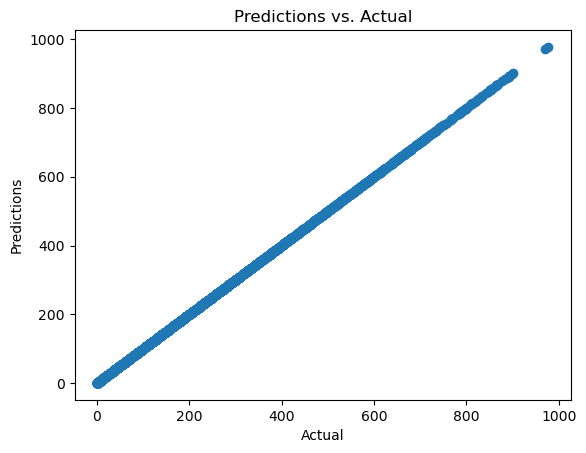

In [183]:
plt.scatter(y_test, predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

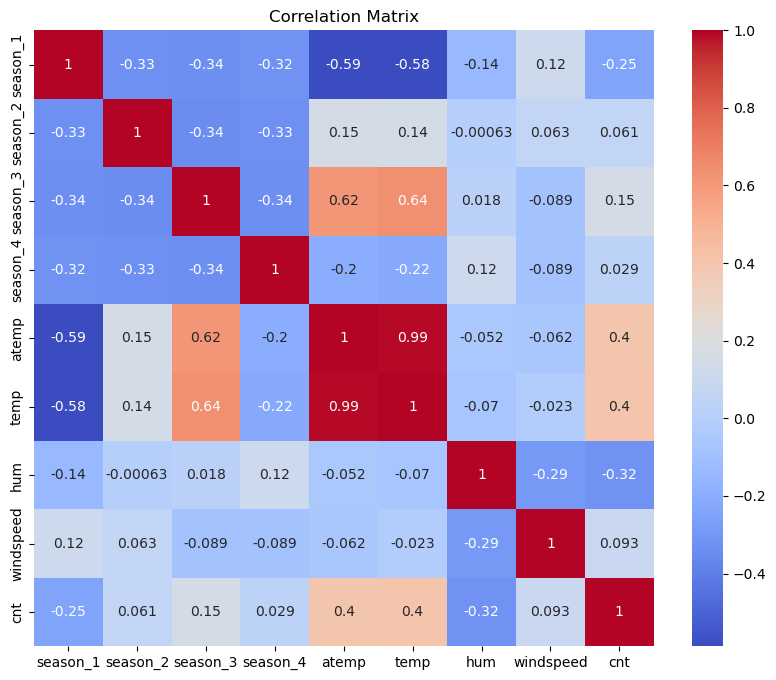

In [205]:
# Select the columns for correlation analysis
columns = ['season_1', 'season_2', 'season_3', 'season_4', 'atemp', 'temp', 'hum', 'windspeed', 'cnt']

# Create a subset of the DataFrame with selected columns
subset = df_enc[columns]

# Compute the correlation matrix
correlation_matrix = subset.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [209]:
sns.pairplot(df_enc, hue="cnt", diag_kind="hist")
plt.show()

In [184]:
import pandas as pd

# Group the data by 'season'
grouped = df.groupby('season')

# Display the grouped data
for season, data in grouped:
    print(f"Season: {season}")
    print(data)
    print()


Season: 1
      season yr mnth  hr holiday weekday workingday weathersit  temp   atemp  \
0          1  0    1   0       0       6          0          1  0.24  0.2879   
1          1  0    1   1       0       6          0          1  0.22  0.2727   
2          1  0    1   2       0       6          0          1  0.22  0.2727   
3          1  0    1   3       0       6          0          1  0.24  0.2879   
4          1  0    1   4       0       6          0          1  0.24  0.2879   
...      ... ..  ...  ..     ...     ...        ...        ...   ...     ...   
17374      1  1   12  19       0       1          1          2  0.26  0.2576   
17375      1  1   12  20       0       1          1          2  0.26  0.2576   
17376      1  1   12  21       0       1          1          1  0.26  0.2576   
17377      1  1   12  22       0       1          1          1  0.26  0.2727   
17378      1  1   12  23       0       1          1          1  0.26  0.2727   

        hum  windspeed  casua

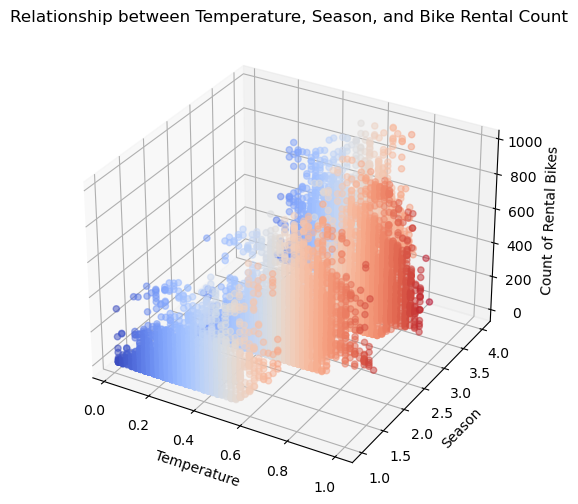

In [185]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert 'season' to integer type
df['season'] = df['season'].astype(int)

# Scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points with different colors for 'temp' and 'season'
ax.scatter(df['temp'], df['season'], df['cnt'], c=df['temp'], cmap='coolwarm', alpha=0.5)

# Set labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('Season')
ax.set_zlabel('Count of Rental Bikes')
ax.set_title('Relationship between Temperature, Season, and Bike Rental Count')

plt.show()


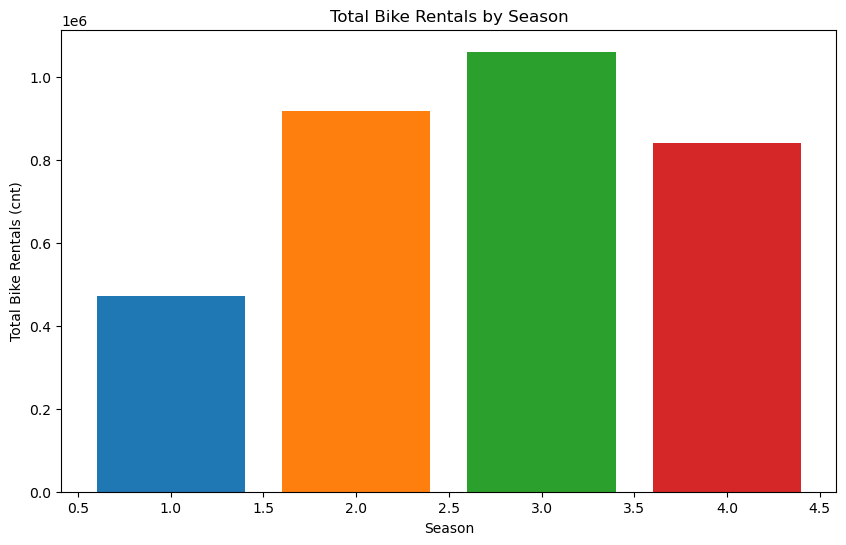

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'season'
grouped = df.groupby('season')

# Plot 'cnt' values for each season
plt.figure(figsize=(10, 6))
for season, data in grouped:
    plt.bar(season, data['cnt'].sum())

plt.xlabel('Season')
plt.ylabel('Total Bike Rentals (cnt)')
plt.title('Total Bike Rentals by Season')
plt.show()


In [188]:
import pandas as pd

# Assuming 'df' is your DataFrame
grouped = df.groupby('season')['cnt'].sum().reset_index()
total_sum = grouped['cnt'].sum()

print("Sum of 'cnt' for each value in the 'season' column:")
print(grouped)

print("\nTotal sum of 'cnt' for all values:")
print(total_sum)


Sum of 'cnt' for each value in the 'season' column:
   season      cnt
0       1   471348
1       2   918589
2       3  1061129
3       4   841613

Total sum of 'cnt' for all values:
3292679


In [189]:
import pandas as pd

# Assuming 'df' is your DataFrame
grouped1 = df.groupby('season')['cnt'].mean().reset_index()
total_mean = grouped['cnt'].mean()

print("Mean of 'cnt' for each value in the 'season' column:")
print(grouped1)

print("\nOverall mean of 'cnt' for all values:")
print(total_mean)


Mean of 'cnt' for each value in the 'season' column:
   season         cnt
0       1  111.114569
1       2  208.344069
2       3  236.016237
3       4  198.868856

Overall mean of 'cnt' for all values:
823169.75


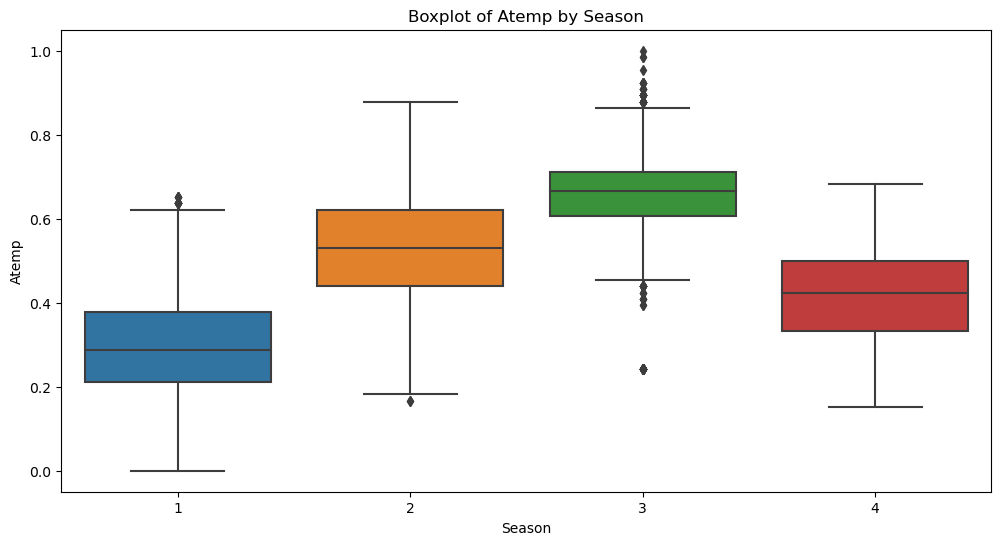

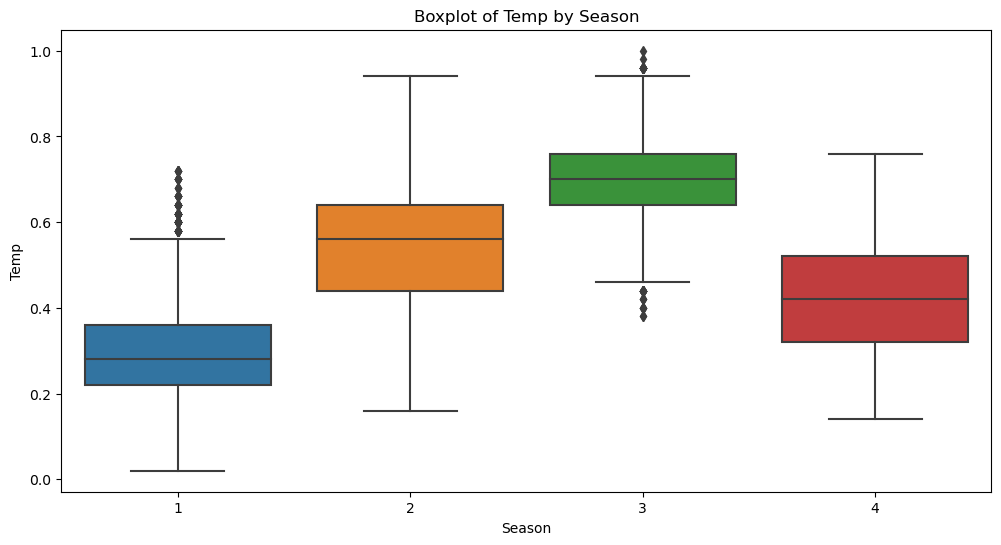

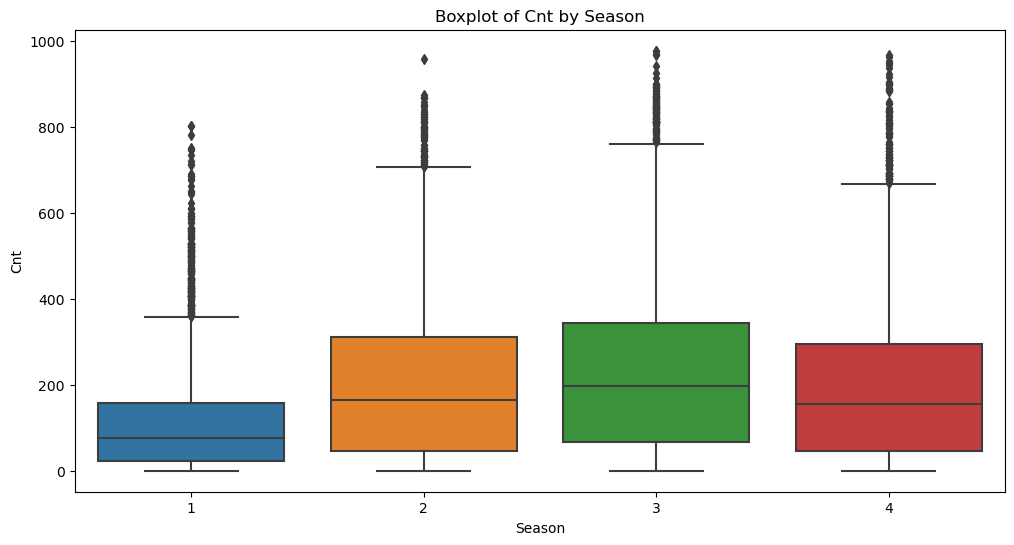

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplots for 'atemp', 'temp', and 'cnt' grouped by 'season'
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='atemp', data=df)
plt.title('Boxplot of Atemp by Season')
plt.xlabel('Season')
plt.ylabel('Atemp')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='temp', data=df)
plt.title('Boxplot of Temp by Season')
plt.xlabel('Season')
plt.ylabel('Temp')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Boxplot of Cnt by Season')
plt.xlabel('Season')
plt.ylabel('Cnt')
plt.show()


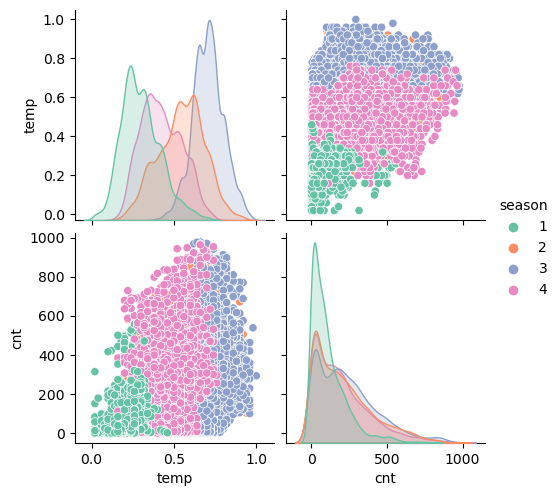

In [ ]:
columns = df[['temp', 'season', 'cnt']]
sns.pairplot(columns, hue='season', palette='Set2')  # pairplot with Set2 color palette
plt.show()


<Axes: xlabel='season'>

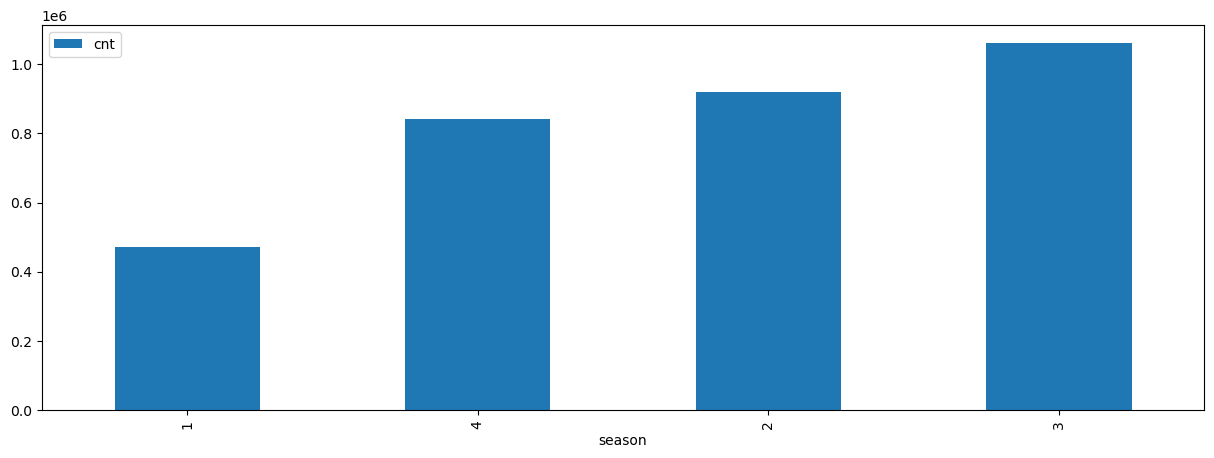

In [ ]:
df.groupby(by=['season'])['cnt'].sum().reset_index().sort_values(['cnt']).tail(10).plot(x='season', y='cnt',
                                                                                                           kind='bar',
                                                                                                           figsize=(15,5))


C:\Users\eterp\AppData\Local\Temp\ipykernel_19460\3753181288.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', center=1)


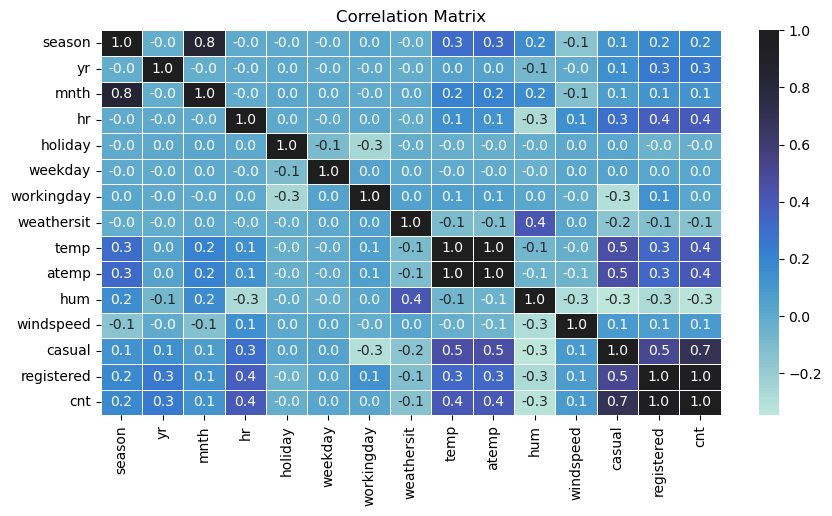

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', center=1)
plt.title('Correlation Matrix')
plt.show()

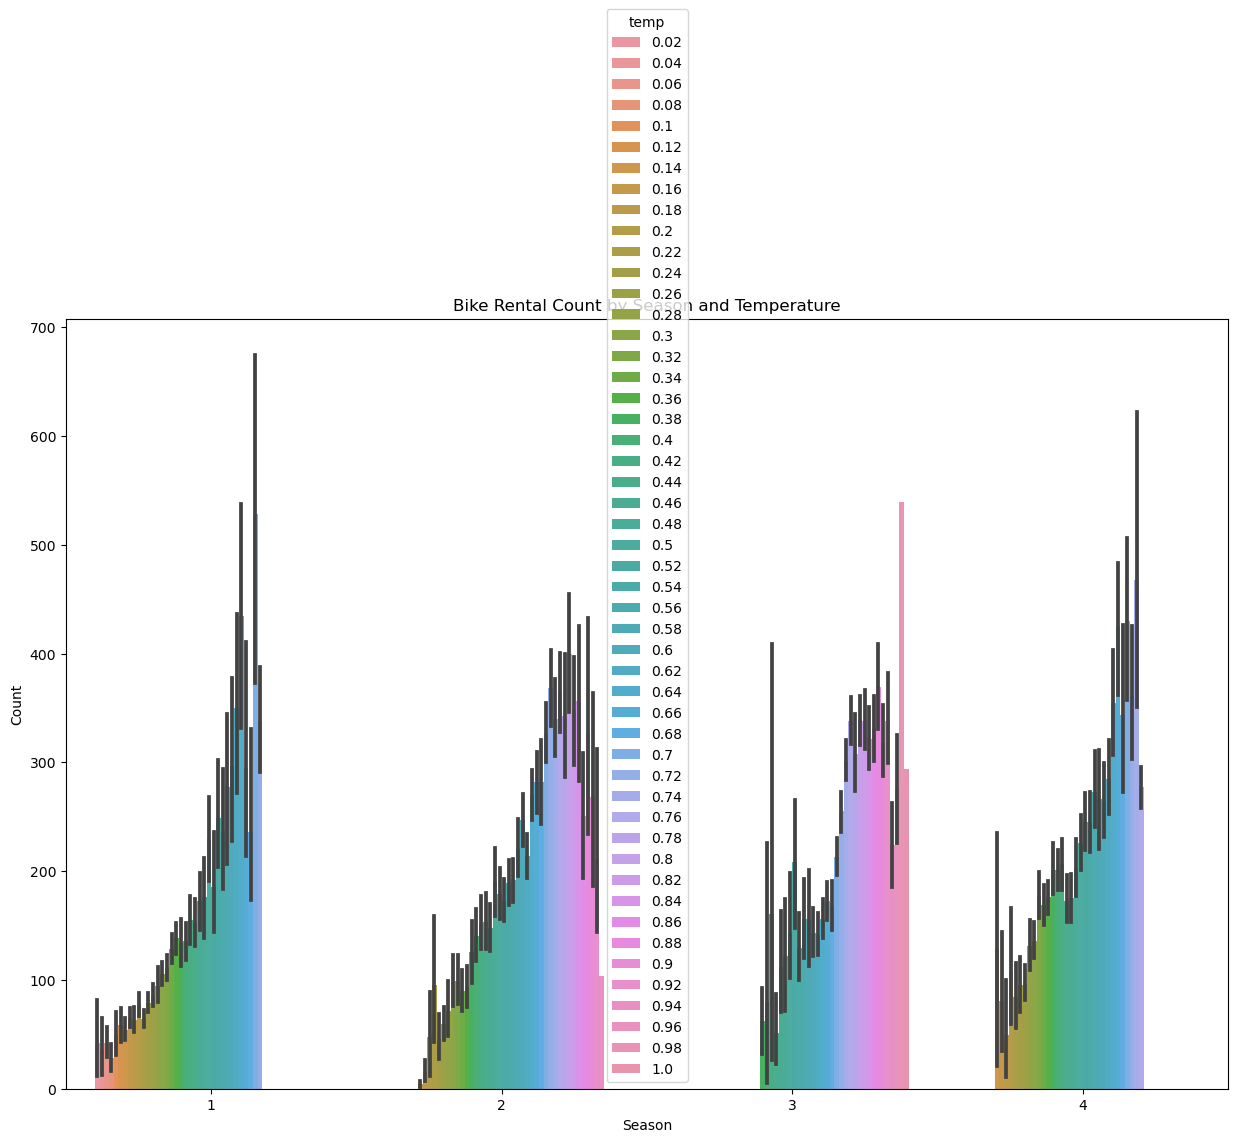

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='season', y='cnt', hue='temp')
plt.title('Bike Rental Count by Season and Temperature')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select the "season" column for encoding
season_data = df[["season"]]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(season_data)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.categories_[0])

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

# Drop the original "season" column
df_encoded = df_encoded.drop("season", axis=1)

# Display the encoded DataFrame
print(df_encoded.head())


       dteday  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0  2011-01-01   0     1   0        0        6           0           1  0.24   
1  2011-01-01   0     1   1        0        6           0           1  0.22   
2  2011-01-01   0     1   2        0        6           0           1  0.22   
3  2011-01-01   0     1   3        0        6           0           1  0.24   
4  2011-01-01   0     1   4        0        6           0           1  0.24   

    atemp   hum  windspeed  casual  registered  cnt    1    2    3    4  
0  0.2879  0.81        0.0       3          13   16  1.0  0.0  0.0  0.0  
1  0.2727  0.80        0.0       8          32   40  1.0  0.0  0.0  0.0  
2  0.2727  0.80        0.0       5          27   32  1.0  0.0  0.0  0.0  
3  0.2879  0.75        0.0       3          10   13  1.0  0.0  0.0  0.0  
4  0.2879  0.75        0.0       0           1    1  1.0  0.0  0.0  0.0  


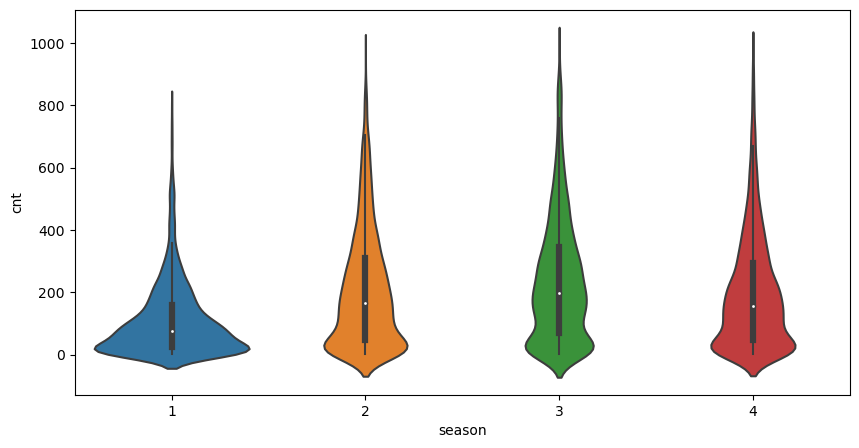

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x=df.season, y=df['cnt'])
plt.show()

# Conduct an ANOVA test on the data

In [ ]:
from scipy import stats

# Select the data for each season
season1 = df[df['season'] == 1]['cnt']
season2 = df[df['season'] == 2]['cnt']
season3 = df[df['season'] == 3]['cnt']
season4 = df[df['season'] == 4]['cnt']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(season1, season2, season3, season4)

# Print the results
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)


ANOVA results:
F-statistic: 409.1810372630525
p-value: 7.40107139971279e-257


The ANOVA test results indicate a significant relationship between the 'season' variable and the 'cnt' variable. The F-statistic is 409.1810372630525, and the p-value is very small (7.40107139971279e-257), suggesting strong evidence against the null hypothesis of no association.

This indicates that the 'season' variable has a significant impact on the 'cnt' variable, and there are likely differences in the mean counts of bike rentals across different seasons.

# Conduct a t test:
H0: There is no significant difference in the mean bike rental counts between the seasons.

Rejecting the null hypothesis would indicate that there is a significant difference in the mean bike rental counts between at least one pair of seasons.

In [ ]:
import scipy.stats as stats

# Define the seasons and corresponding subsets of 'cnt' variable
seasons = df['season'].unique()

# Perform pairwise t-tests between each season and 'cnt'
for season in seasons:
    season_data = df[df['season'] == season]['cnt']
    _, p_value = stats.ttest_ind(season_data, df['cnt'])
    print(f"Season: {season} | p-value: {p_value}")


Season: 1 | p-value: 3.4509642647585406e-155
Season: 2 | p-value: 9.24999633777696e-10
Season: 3 | p-value: 6.144586704479224e-51
Season: 4 | p-value: 0.0025315864887008985


With a significance level of 95% (α = 0.05), we compare the obtained p-values with the chosen significance level to determine the statistical significance. 

Based on the t-tests conducted, the p-values are as follows:

Season 1 vs 'cnt': p-value = 3.4509642647585406e-155 (significant)
Season 2 vs 'cnt': p-value = 9.24999633777696e-10 (significant)
Season 3 vs 'cnt': p-value = 6.144586704479224e-51 (significant)
Season 4 vs 'cnt': p-value = 0.0025315864887008985 (significant)

Since all p-values are much smaller than the significance level of 0.05, we can conclude that there is strong evidence to reject the null hypothesis. This means that there is a statistically significant difference between each season and the 'cnt' variable at the 95% confidence level.

In other words, we can confidently state that the different seasons have a significant impact on the bike rental counts.